In [1]:
import os
import csv
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from collections import defaultdict

from utils import savefig

plt.rcParams['font.size'] = 14

## Vary temporal discount factor
### load data and create a pandas dataframe

In [11]:
data_folder = Path("./experiments/FreeRecall/VaryGamma/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/FreeRecall/VaryGamma/saved_models/ValueMemoryGRU")
setup_names = os.listdir(data_folder)
temporal_discount_factors = np.arange(0.0, 1.1, 0.1)
performance_threshold = 0.7


data = []


for temporal_discount_factor, setup_name in zip(temporal_discount_factors, setup_names):
    for i in range(20):
        data_path = data_folder / setup_name / str(i)
        data_single_model = {}
        with open(data_path/"contiguity_effect.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0]) >= performance_threshold:
                    data_single_model["temporal_discount_factor"] = temporal_discount_factor
                    data_single_model["accuracy"] = float(row[0])
                    data_single_model["forward_asymmetry"] = float(row[1])
                    data_single_model["temporal_factor"] = float(row[2])
                    
                    classifier_data = pickle.load(open(data_path/"decoding_data"/"ridge_classifier_stat.pkl", "rb"))
                    data_single_model["index_decoding_accuracy_encoding_phase"] = classifier_data["index_enc_acc"]
                    data_single_model["item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc"]
                    data_single_model["last_item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc_last"]
                    data_single_model["index_decoding_accuracy_recall_phase"] = classifier_data["index_rec_acc"]
                    data_single_model["item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc"]
                    data_single_model["last_item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc_last"]

                    training_data_path = training_curve_folder / (setup_name + '-' + str(i))
                    training_data = np.load(training_data_path/"accuracy_2.npy")
                    # find the final consecutive zeros in the training data and set it to the last non-zero value
                    zero_indices = np.where(training_data == 0)[0]
                    if len(zero_indices) > 0:
                        last_zero_index = zero_indices[0]
                        training_data[last_zero_index:] = training_data[last_zero_index-1]
                    data_single_model["training_accuracy"] = training_data

                    data.append(data_single_model)

df_tdf = pd.DataFrame(data)
df_tdf.head()


,temporal_discount_factor,accuracy,forward_asymmetry,temporal_factor,index_decoding_accuracy_encoding_phase,item_decoding_accuracy_encoding_phase,last_item_decoding_accuracy_encoding_phase,index_decoding_accuracy_recall_phase,item_decoding_accuracy_recall_phase,last_item_decoding_accuracy_recall_phase,training_accuracy
0,0.0,0.861425,0.374882,0.425399,0.558350,0.940775,0.439600,0.400795,0.605457,0.677791,"[0.386171875, 0.655703125, 0.73034375, 0.80189..."
1,0.0,0.993800,0.642385,0.437338,0.754650,0.937200,0.637943,0.394595,0.692550,0.862130,"[0.345375, 0.593828125, 0.715515625, 0.7920312..."
2,0.0,0.830025,0.486335,0.493819,0.841775,0.996225,0.487800,0.570022,0.650013,0.802829,"[0.42096875, 0.657734375, 0.750796875, 0.83360..."
3,0.0,0.990675,0.461366,0.384612,0.564075,0.791825,0.420257,0.180213,0.512323,0.568549,"[0.3609375, 0.62203125, 0.703203125, 0.7745781..."
4,0.0,0.881625,0.503165,0.406364,0.627325,0.897425,0.497857,0.450624,0.657312,0.656437,"[0.36684375, 0.65771875, 0.773328125, 0.815453..."


### average training curve by temporal discount factor

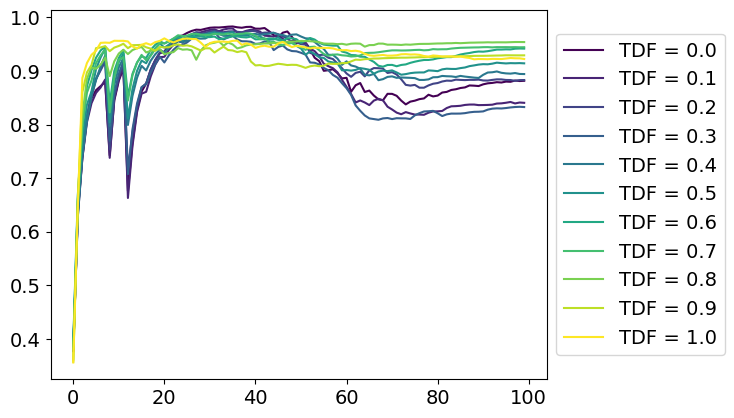

In [12]:
training_accuracy_by_tdf = df_tdf.groupby("temporal_discount_factor")["training_accuracy"].mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_by_tdf)))
for i, (tdf, acc) in enumerate(training_accuracy_by_tdf.items()):
    plt.plot(acc[:100], label=f"TDF = {tdf:.1f}", color=colors[i])
# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


### plot the average accuracy, temporal factor, and forward asymmetry by temporal discount factor

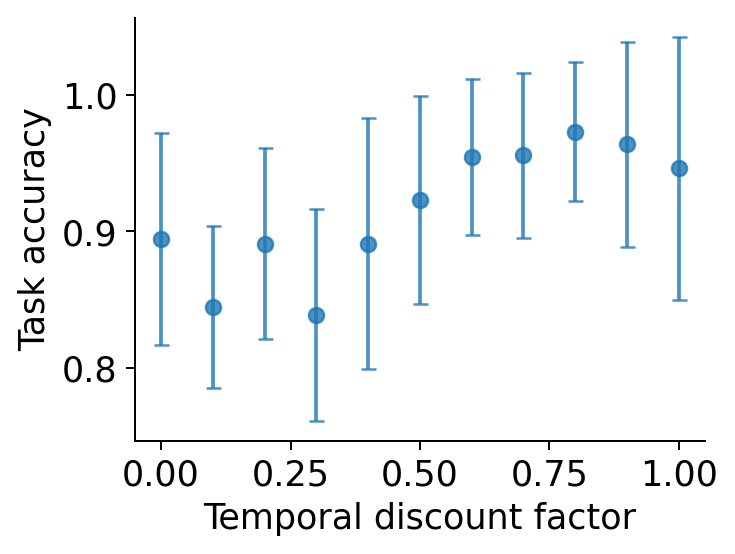

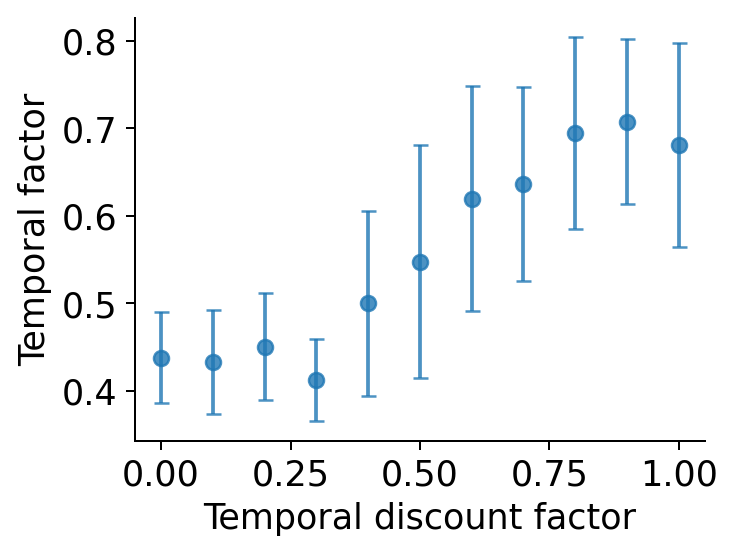

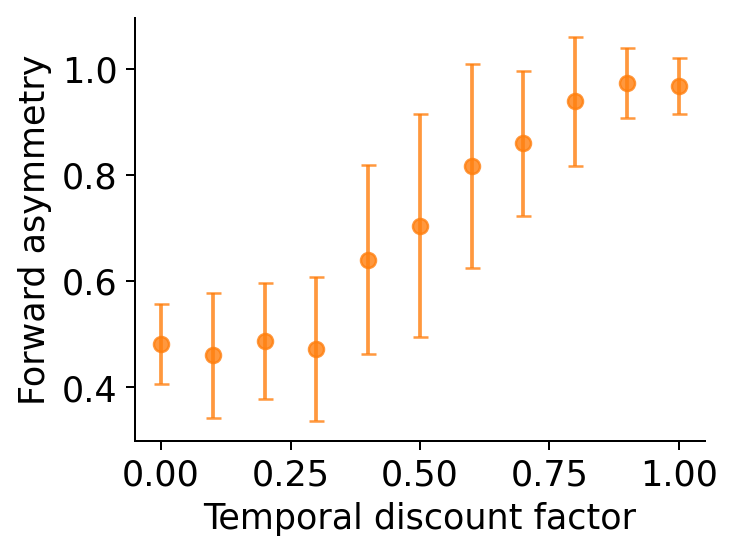

In [13]:
accuracy_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["accuracy"].mean()
accuracy_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["accuracy"].std()

temporal_factor_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["temporal_factor"].mean()
temporal_factor_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["temporal_factor"].std()

forward_asymmetry_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["forward_asymmetry"].mean()
forward_asymmetry_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["forward_asymmetry"].std()



### plot the average accuracy, temporal factor, forward asymmetry and index decoding accuracy by temporal discount factor
def plot_mean_std(x, y, yerr, x_label, y_label, color='tab:blue', figname=None):
    fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/vary_gamma", figname)
    else:
        plt.show()

plot_mean_std(temporal_discount_factors, accuracy_mean_by_tdf, accuracy_std_by_tdf, "Temporal discount factor", "Task accuracy", color='tab:blue')
plot_mean_std(temporal_discount_factors, temporal_factor_mean_by_tdf, temporal_factor_std_by_tdf, "Temporal discount factor", "Temporal factor", color='tab:blue')
plot_mean_std(temporal_discount_factors, forward_asymmetry_mean_by_tdf, forward_asymmetry_std_by_tdf, "Temporal discount factor", "Forward asymmetry", color='tab:orange')


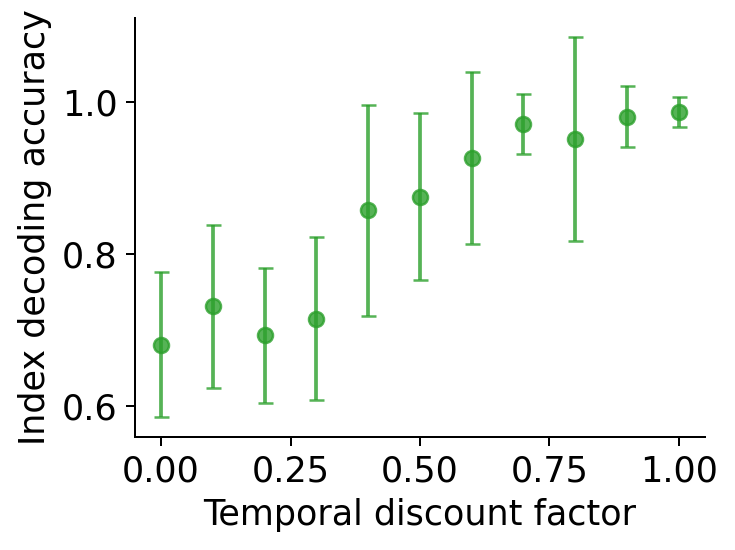

In [14]:
# decoding accuracy by temporal discount factor
index_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["index_decoding_accuracy_encoding_phase"].mean()
index_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["index_decoding_accuracy_encoding_phase"].std()

# item_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_encoding_phase"].mean()
# item_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_encoding_phase"].std()

# last_item_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_encoding_phase"].mean()
# last_item_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_encoding_phase"].std()

# index_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["index_decoding_accuracy_recall_phase"].mean()
# index_decoding_accuracy_recall_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["index_decoding_accuracy_recall_phase"].std()

# item_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_recall_phase"].mean()
# item_decoding_accuracy_recall_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_recall_phase"].std()

# last_item_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_recall_phase"].mean()
# last_item_decoding_accuracy_recall_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_recall_phase"].std()


plot_mean_std(temporal_discount_factors, index_decoding_accuracy_encoding_phase_mean_by_tdf, index_decoding_accuracy_encoding_phase_std_by_tdf, "Temporal discount factor", "Index decoding accuracy", color='tab:green')
# plot_mean_std(temporal_discount_factors, index_decoding_accuracy_encoding_phase_mean_by_tdf, index_decoding_accuracy_encoding_phase_std_by_tdf, "Temporal discount factor", "Index decoding accuracy\n(encoding phase)", color='tab:green')
# plot_mean_std(temporal_discount_factors, item_decoding_accuracy_encoding_phase_mean_by_tdf, item_decoding_accuracy_encoding_phase_std_by_tdf, "Temporal discount factor", "Item decoding accuracy\n(encoding phase)")
# plot_mean_std(temporal_discount_factors, last_item_decoding_accuracy_encoding_phase_mean_by_tdf, last_item_decoding_accuracy_encoding_phase_std_by_tdf, "Temporal discount factor", "Last item decoding accuracy\n(encoding phase)")

# plot_mean_std(temporal_discount_factors, index_decoding_accuracy_recall_phase_mean_by_tdf, index_decoding_accuracy_recall_phase_std_by_tdf, "Temporal discount factor", "Index decoding accuracy\n(recall phase)")
# plot_mean_std(temporal_discount_factors, item_decoding_accuracy_recall_phase_mean_by_tdf, item_decoding_accuracy_recall_phase_std_by_tdf, "Temporal discount factor", "Item decoding accuracy\n(recall phase)")
# plot_mean_std(temporal_discount_factors, last_item_decoding_accuracy_recall_phase_mean_by_tdf, last_item_decoding_accuracy_recall_phase_std_by_tdf, "Temporal discount factor", "Last item decoding accuracy\n(recall phase)")


### accuracy by forward asymmetry, temporal factor and index decoding accuracy

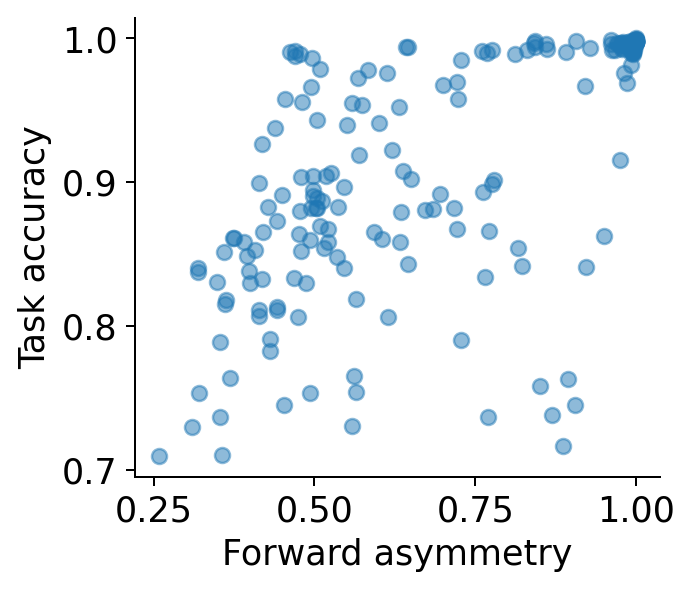

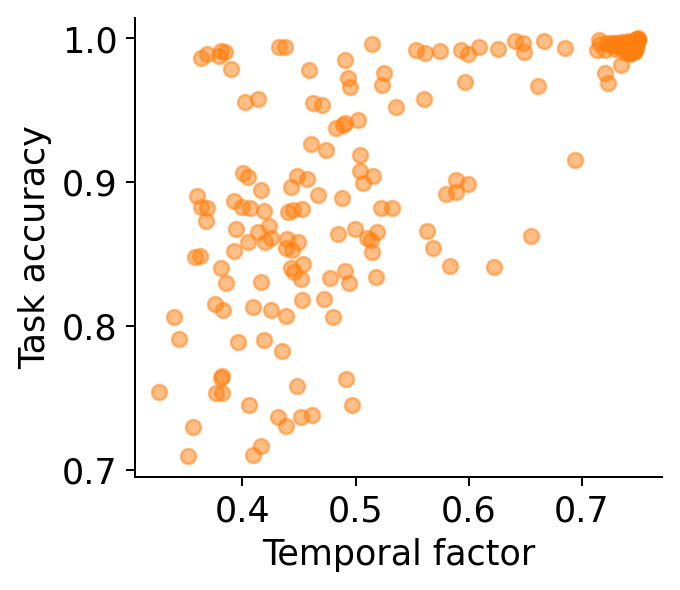

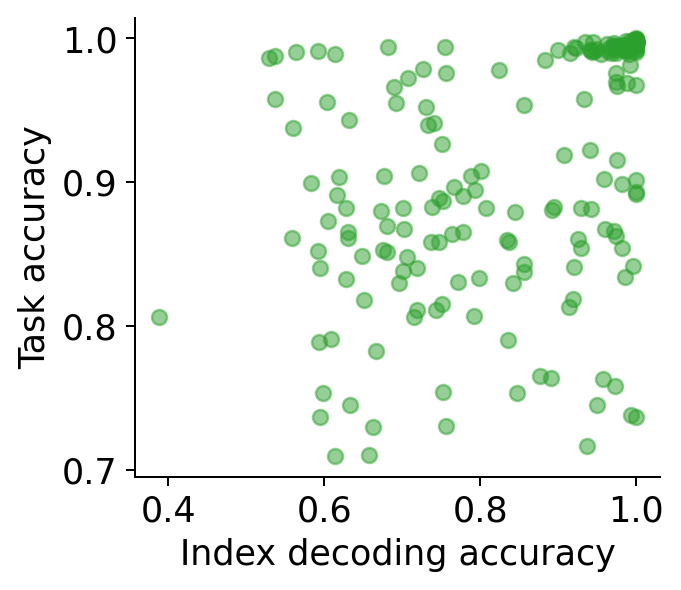

In [18]:
def plot_scatter(x, y, x_label, y_label, color='tab:blue', figname=None):
    plt.figure(figsize=(4, 3.5), dpi=180)
    plt.scatter(x, y, alpha=0.5, color=color)

    plt.ylabel(y_label)
    plt.xlabel(x_label)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/scatter", figname)
    else:
        plt.show()


plot_scatter(df_tdf["forward_asymmetry"], df_tdf["accuracy"], "Forward asymmetry", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf["temporal_factor"], df_tdf["accuracy"], "Temporal factor", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf["index_decoding_accuracy_encoding_phase"], df_tdf["accuracy"], "Index decoding accuracy", "Task accuracy", color='tab:green')

## vary noise level

In [24]:
data_folder2 = Path("./experiments/FreeRecall/VaryNoise/figures/ValueMemoryGRU")
training_curve_folder2 = Path("./experiments/FreeRecall/VaryNoise/saved_models/ValueMemoryGRU")
setup_names2 = ["setup_seq8_noise{}".format(i) for i in ["0", "02", "04", "06", "08", "1"]]
noise_levels = np.arange(0.0, 1.1, 0.2)
performance_threshold = 0.7

data2 = []


for noise_level, setup_name in zip(noise_levels, setup_names2):
    for i in range(20):
        data_path = data_folder2 / setup_name / str(i)
        data_single_model = {}
        with open(data_path/"contiguity_effect.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0]) >= performance_threshold:
                    data_single_model["noise_level"] = noise_level
                    data_single_model["accuracy"] = float(row[0])
                    data_single_model["forward_asymmetry"] = float(row[1])
                    data_single_model["temporal_factor"] = float(row[2])
                    
                    classifier_data = pickle.load(open(data_path/"decoding_data"/"ridge_classifier_stat.pkl", "rb"))
                    data_single_model["index_decoding_accuracy_encoding_phase"] = classifier_data["index_enc_acc"]
                    data_single_model["item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc"]
                    data_single_model["last_item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc_last"]
                    data_single_model["index_decoding_accuracy_recall_phase"] = classifier_data["index_rec_acc"]
                    data_single_model["item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc"]
                    data_single_model["last_item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc_last"]

                    training_data_path = training_curve_folder2 / (setup_name + '-' + str(i))
                    try:
                        training_data = np.load(training_data_path/"accuracy_2.npy")
                    except:
                        continue
                    # find the final consecutive zeros in the training data and set it to the last non-zero value
                    zero_indices = np.where(training_data == 0)[0]
                    if len(zero_indices) > 0:
                        last_zero_index = zero_indices[0]
                        training_data[last_zero_index:] = training_data[last_zero_index-1]
                    data_single_model["training_accuracy"] = training_data

                    data2.append(data_single_model)

df_noise = pd.DataFrame(data2)
df_noise.head()


,noise_level,accuracy,forward_asymmetry,temporal_factor,index_decoding_accuracy_encoding_phase,item_decoding_accuracy_encoding_phase,last_item_decoding_accuracy_encoding_phase,index_decoding_accuracy_recall_phase,item_decoding_accuracy_recall_phase,last_item_decoding_accuracy_recall_phase,training_accuracy
0,0.0,0.988600,0.308779,0.576827,0.742675,1.0,0.789571,0.453196,0.832532,0.999571,"[0.249984375, 0.375703125, 0.44971875, 0.50907..."
1,0.0,0.993250,0.180116,0.671585,0.845825,1.0,0.856057,0.672285,0.898207,0.997364,"[0.26246875, 0.38896875, 0.466015625, 0.535234..."
2,0.0,0.989025,0.497884,0.374543,0.342625,1.0,0.486686,0.126616,0.813264,0.997563,"[0.2698125, 0.3754375, 0.44459375, 0.50121875,..."
3,0.0,0.993250,0.994350,0.746786,0.976925,1.0,0.975029,0.973827,0.999024,0.999170,"[0.33328125, 0.5765625, 0.8905625, 0.987046875]"
4,0.0,0.991200,0.503067,0.375130,0.393700,1.0,0.463829,0.142280,0.827012,0.991911,"[0.367046875, 0.65009375, 0.504171875, 0.09917..."


### accuracy by forward asymmetry, temporal factor and index decoding accuracy

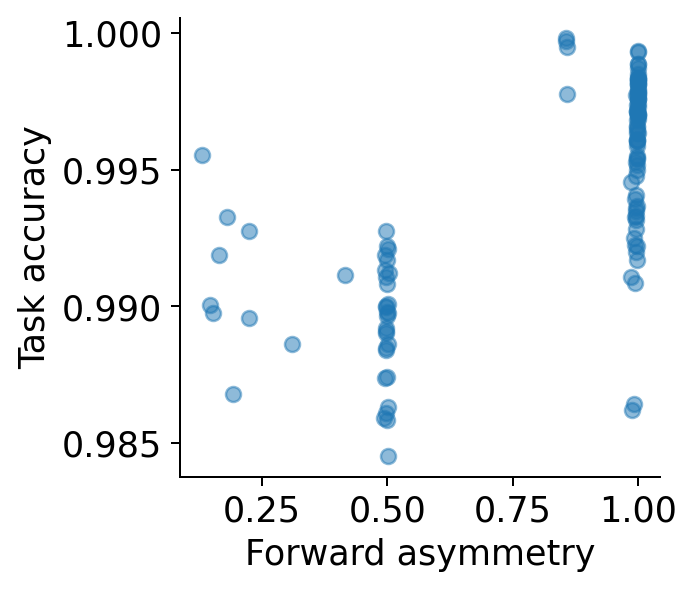

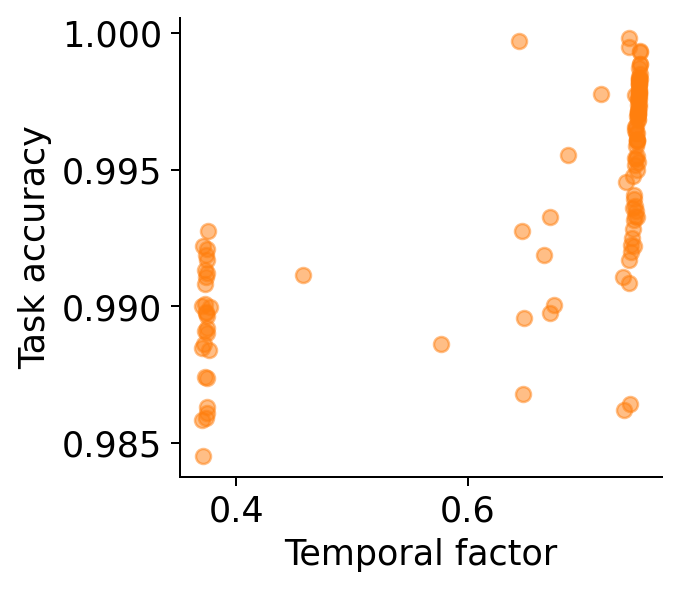

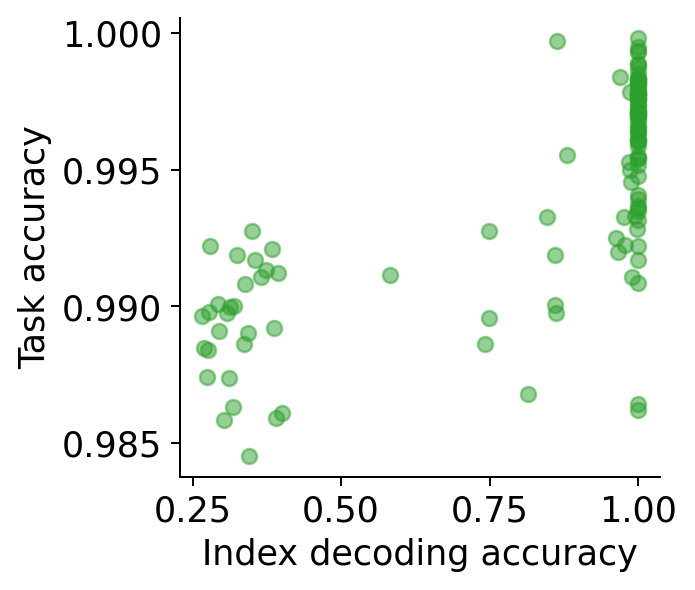

In [25]:
plot_scatter(df_noise["forward_asymmetry"], df_noise["accuracy"], "Forward asymmetry", "Task accuracy", color='tab:blue')
plot_scatter(df_noise["temporal_factor"], df_noise["accuracy"], "Temporal factor", "Task accuracy", color='tab:orange')
plot_scatter(df_noise["index_decoding_accuracy_encoding_phase"], df_noise["accuracy"], "Index decoding accuracy", "Task accuracy", color='tab:green')

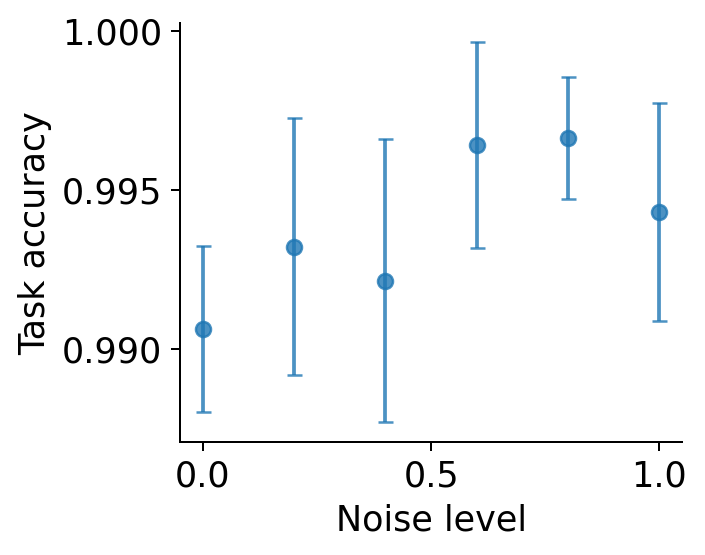

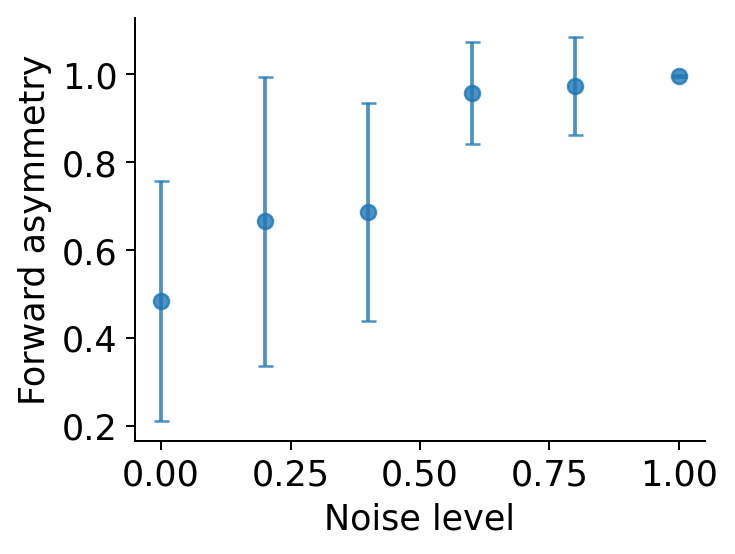

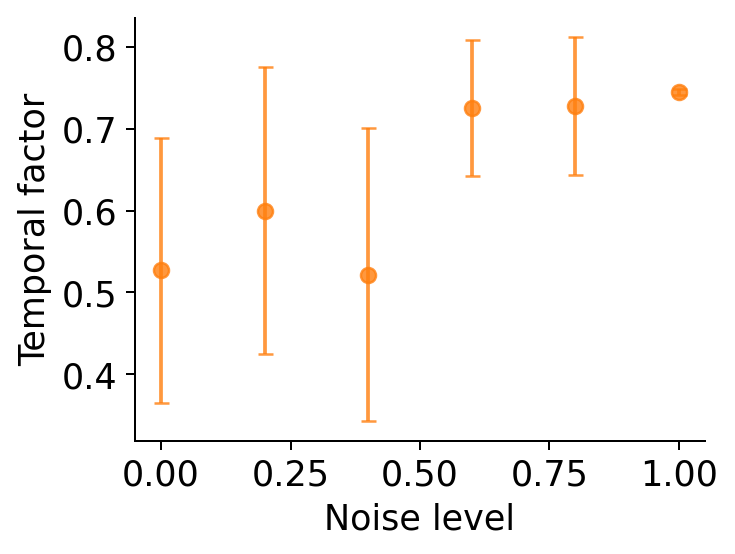

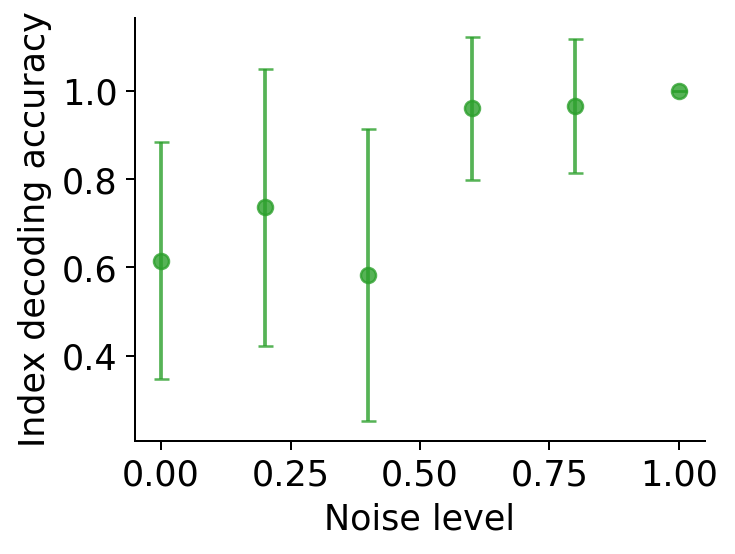

In [26]:
# accuracy, forward asymmetry, temporal factor, index decoding accuracy by noise level
accuracy_mean_by_noise_level = df_noise.groupby("noise_level")["accuracy"].mean()
accuracy_std_by_noise_level = df_noise.groupby("noise_level")["accuracy"].std()

forward_asymmetry_mean_by_noise_level = df_noise.groupby("noise_level")["forward_asymmetry"].mean()
forward_asymmetry_std_by_noise_level = df_noise.groupby("noise_level")["forward_asymmetry"].std()

temporal_factor_mean_by_noise_level = df_noise.groupby("noise_level")["temporal_factor"].mean()
temporal_factor_std_by_noise_level = df_noise.groupby("noise_level")["temporal_factor"].std()

index_decoding_accuracy_encoding_phase_mean_by_noise_level = df_noise.groupby("noise_level")["index_decoding_accuracy_encoding_phase"].mean()
index_decoding_accuracy_encoding_phase_std_by_noise_level = df_noise.groupby("noise_level")["index_decoding_accuracy_encoding_phase"].std()


plot_mean_std(noise_levels, accuracy_mean_by_noise_level, accuracy_std_by_noise_level, "Noise level", "Task accuracy", color='tab:blue')
plot_mean_std(noise_levels, forward_asymmetry_mean_by_noise_level, forward_asymmetry_std_by_noise_level, "Noise level", "Forward asymmetry", color='tab:blue')
plot_mean_std(noise_levels, temporal_factor_mean_by_noise_level, temporal_factor_std_by_noise_level, "Noise level", "Temporal factor", color='tab:orange')
plot_mean_std(noise_levels, index_decoding_accuracy_encoding_phase_mean_by_noise_level, index_decoding_accuracy_encoding_phase_std_by_noise_level, "Noise level", "Index decoding accuracy", color='tab:green')

